In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [2]:
# read in the data 
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')

In [3]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

This should take 1-2 minutes, but changing the step size would speed it up if you need.

In [4]:
%%time
# we want to store the components and the length of the largest component
lengths = []
components = list()

# at each threshold, we remove the edges that are longer than the threshold
for i in np.arange(0, edges.l.max()):
    G_ = G.copy()
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['l'] > i]
    
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)
    
components = pd.concat(components)
components.head()

CPU times: user 1min 36s, sys: 226 ms, total: 1min 36s
Wall time: 1min 36s


component  threshold  gcc
8211             0        0.0    1
2333             1        0.0    1
1000559          2        0.0    1
1000567          3        0.0    1
5425             4        0.0    1

In [5]:
def clean_components(dataframe, nodes=nodes, edges=edges, steps=np.append(np.arange(10, 450, 10), 600)):
    edges_copy = edges.copy()
    nodes_copy = nodes.copy()

    components_copy = dataframe[dataframe.threshold.isin(steps)].merge(nodes_copy,
                                                                                         left_index=True, right_on='Agglomeration_ID', how='left')

    # just clean up the columns so they are all unique identifiers
    components_copy['aggnm'] = components_copy['agglosName']
    components_copy['pop15'] = components_copy['Pop2015']
    components_copy['thrno'] = components_copy['threshold']
    components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

    components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]

    # we are going to tag each component with the biggest city in it so that we can track the components over time (the component numbers are not consistent across runs)
    biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
    biggest['biggest_rank'] = biggest.pop15.rank(ascending=False, method='dense')
    # let's all get population statistics for the biggest city in each component
    n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
    n_comps.columns = [''.join(x) for x in n_comps.columns]
    # merge the biggest city and the number of cities in the component
    components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                            left_on=['thrid', 'comid'], 
                                            right_on=['thrid', 'comid'], 
                                            how='left').merge(n_comps, 
                                                              left_on=['thrid', 'comid'], 
                                                              right_on=['thrid', 'comid'], 
                                                              how='left').sort_values('pop15count', ascending=False)
    
    return components_copy
    

In [185]:
components_copy = clean_components(components)

In [178]:
# africa basemap
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

In [179]:
# hacky way to make a discrete palette that looks okay
from colorcet import palette
from matplotlib import colors
pal = np.tile(palette['glasbey'], len(nodes) // len(palette['glasbey']))
pal = colors.ListedColormap(pal)

In [186]:
# case when pop15count is 1, biggest_rank should equal 10000
components_copy['biggest_rank'] = np.where(components_copy['pop15count']==1, 500, components_copy['biggest_rank'])
# where biggest_rank is over 100, set it to 1000
components_copy['biggest_rank'] = np.where(components_copy['biggest_rank']>256, 500, components_copy['biggest_rank'])
# create a column with biggest city called city_tag
components_copy['city_tag'] = components_copy['biggest_city']
# where the rank is 500, set city_tag to other
components_copy['city_tag'] = np.where(components_copy['biggest_rank']==500, 'Other', components_copy['biggest_city'])

In [213]:
# make a crosswalk where each unique rank is assigned a unique color but 500 is assigned a grey
cw = components_copy.groupby('biggest_rank', as_index=False).first().sort_values('biggest_rank', ascending=False)
cw = cw[['biggest_rank', 'city_tag']]
cw['color'] = np.append('#999999', cc.glasbey[:len(cw)-1])

Text(143.5, 0.5, 'GCC (nodes)')

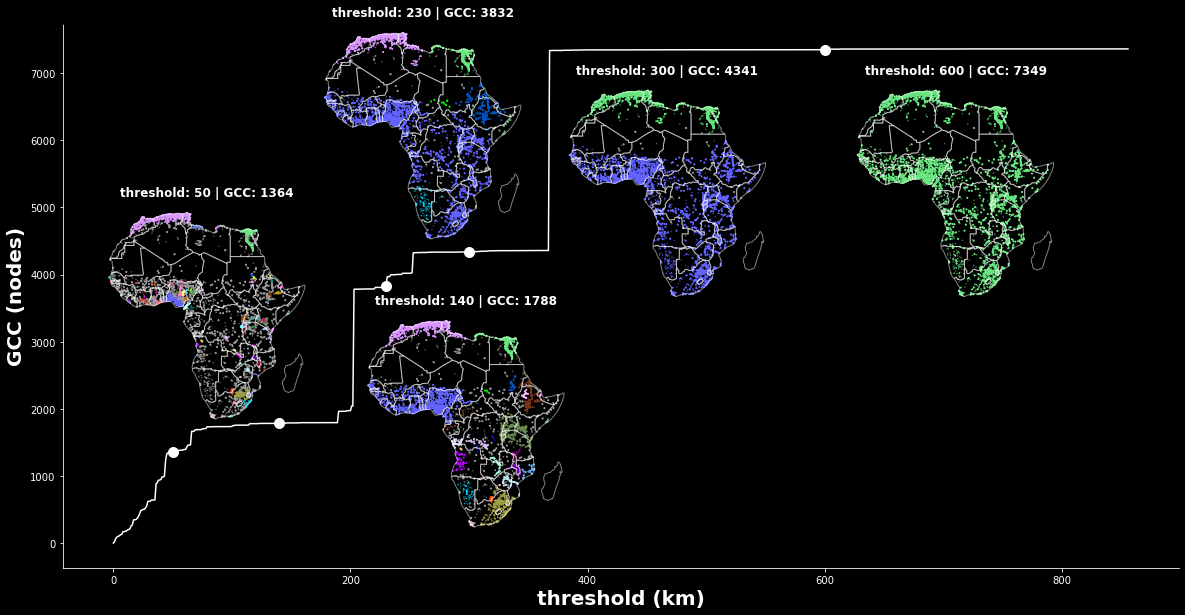

In [215]:
# we are going to show some maps, so here we specify size
size = [0.15, 0.35]
# thresholds we want maps of 
selection = [50, 140, 230, 300, 600]
# show the points of these along the curve
points = components[components.threshold.isin(selection)].groupby('threshold').first().reset_index()

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')
ax.plot(np.arange(0, edges.l.max()), lengths, color='w')

# plot a bunch of maps of the components at different thresholds
for i, j in zip(selection, [[0.15, 0.30], [0.33, 0.15], [0.30, 0.55], [0.47, 0.47], [0.67, 0.47]]):
    
    sub = plt.axes(j + size, facecolor='#000000')
    
    temp_comps = components_copy[components_copy['thrno']==i]

    g = temp_comps.gcc.iloc[0]

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes = temp_nodes.merge(cw, left_on='biggest_rank', right_on='biggest_rank')
    temp_nodes['component'] = temp_nodes['color']
    
    temp_marks= (np.log(temp_nodes['Pop2015'] + 1) + 1) / 10
    temp_nodes.plot(color=temp_nodes['component'], markersize=temp_marks, ax=sub)
    
    africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='w', weight='bold')
    sub.set_axis_off()
    
# plot the reference points
ax.scatter(points.threshold.to_numpy(), points.gcc.to_numpy(), s=100, c='w')

# clean it up
ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("threshold (km)", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)

we need to build a hierarchical tree that shows the nested structures of cities. I think about it as a network, this way: each city is a node, and each city has a parent node, which is the city that contains it. The root node is africa. We want to draw an edge list that takes an agglomeration ID at time t and finds its component at time t+1...

In [216]:
edge_list = list()
# dendrogram only needs a subset of thresholds
thresholds = np.append(np.arange(0, 400, 50), 600)

for i in np.arange(1, len(thresholds)-1):
    # layer t
    test_t0 = components_copy[components_copy['thrno']==thresholds[i]]
    # layer t+1
    test_t1 = components_copy[components_copy['thrno']==thresholds[i+1]]
    # grab the biggest city in each component
    biggest_t0 = test_t0.sort_values('pop15', ascending=False).groupby('comid', as_index=False).first()
    # grab the columns we want
    biggest_t0 = biggest_t0[['aggid', 'thrid', 'comid']]
    
    # merge the biggest city in each component with the layer t+1
    biggest_t1 = test_t1.sort_values('pop15', ascending=False).groupby('comid', as_index=False).first()
    # grab the columns we want again
    biggest_t1 = biggest_t1[['aggid', 'thrid', 'comid']]

    # give all cities in each component the biggest city (x, y)
    cross_t1 = test_t1.merge(biggest_t1, left_on='comid', right_on='comid', how='left').sort_values('comid')
    cross_t1 = cross_t1[['aggid_x', 'aggid_y', 'thrid_y']]

    # now join the biggest city in t with its counterpart in t+1
    t0_edges = biggest_t0[['aggid', 'thrid']].merge(cross_t1, left_on='aggid', right_on='aggid_x', how='left')
    t0_edges['from'] = t0_edges['aggid'] + t0_edges['thrid']
    t0_edges['to'] = t0_edges['aggid_y'] + t0_edges['thrid_y']

    # we end up with an edge list
    t0_edges = t0_edges[['from', 'to', 'thrid']]
    t0_edges['thrid'] = t0_edges.thrid.astype('int')
    
    edge_list.append(t0_edges)

In [217]:
edge_list = pd.concat(edge_list, ignore_index=True)
edge_list.head()

from              to  thrid
0  00023410000050  00023410000100     50
1  00023200000050  00023200000100     50
2  00051990000050  00051990000100     50
3  00042200000050  00042200000100     50
4  00083820000050  00023410000100     50

In [300]:
G_nest = nx.from_pandas_edgelist(edge_list, source='from', target='to', edge_attr=['thrid'])
G_comp = sorted(nx.connected_components(G_nest), key=len, reverse=True)
G_comp = G_nest.subgraph(G_comp[0])

In [302]:
components_copy['identifier'] = components_copy['aggid'] + components_copy['thrid']

In [304]:
# let's make each circle in the dendrogram proportional to the population of that component, and colour it by the biggest city throughout
component_population = components_copy.groupby(['comid', 'thrid'], as_index=False).agg({'pop15': 'sum'}).rename(columns={'pop15': 'pop_total'})

component_labels = components_copy.sort_values('pop15', ascending=False).groupby('identifier', as_index=False).agg({'comid': 'first', 'thrid': 'first', 'pop15': 'sum', 'biggest_city': 'first', 'biggest_rank': 'first'})
component_labels = component_labels.merge(component_population, left_on=['comid', 'thrid'], right_on=['comid', 'thrid'])
component_labels = component_labels.merge(cw, left_on='biggest_rank', right_on='biggest_rank')
component_labels.set_index('identifier', inplace=True)
component_labels.head()

comid    thrid   pop15 biggest_city  biggest_rank  \
identifier                                                            
00000010000010  0000003  0000010  158515        Cairo           1.0   
00000920000010  0000003  0000010  280974        Cairo           1.0   
00000980000010  0000003  0000010  176133        Cairo           1.0   
00001270000010  0000003  0000010  132148        Cairo           1.0   
00004610000010  0000003  0000010   30767        Cairo           1.0   

                pop_total city_tag    color  
identifier                                   
00000010000010   27647292    Cairo  #69e680  
00000920000010   27647292    Cairo  #69e680  
00000980000010   27647292    Cairo  #69e680  
00001270000010   27647292    Cairo  #69e680  
00004610000010   27647292    Cairo  #69e680

In [305]:
nx.set_node_attributes(G_comp, component_labels.to_dict('index'))

In [306]:
# let's grab just the top 25 cities to label, and we want to label them at the highest threshold at which they are the biggest city in a component
node_labels = components_copy.copy()
node_labels = node_labels[node_labels.identifier.isin(list(G_comp.nodes()))]
node_labels = node_labels.sort_values('pop15', ascending=False).groupby(['comid', 'thrid'], as_index=False).first()
node_labels = node_labels.sort_values('thrno', ascending=False).groupby('aggid', as_index=False).first()
node_labels = node_labels.nlargest(25, 'pop15')
node_labels['identifier'] = node_labels['aggid'] + node_labels['thrid']
node_labels = node_labels[~node_labels.aggnm.isin(["Abidjan", "Kisii", "Kisumu", "Yaoundé"])]

blanks = pd.DataFrame({'identifier': components_copy[~components_copy.identifier.isin(node_labels.identifier)].identifier,
                       'aggnm': " "})

node_labels = pd.concat([node_labels[['identifier', 'aggnm']], blanks]) 
node_labels = node_labels[node_labels.identifier.isin(list(G_comp.nodes()))]

node_labels.head(20)

identifier             aggnm
137  00023200000600             Cairo
397  00051990000350             Lagos
300  00042200000200      Johannesburg
364  00048580000150          Kinshasa
410  00053310000150            Luanda
518  00065090000150           Nairobi
178  00026220000100     Dar es Salaam
354  00047400000250           Khartum
7    00001450000050             Accra
141  00023410000250        Casablanca
330  00045190000050              Kano
8    00001590000100       Addis Ababa
138  00023330000200         Cape Town
209  00029150000050            Durban
173  00025450000100             Dakar
390  00051120000050            Kumasi
59   00015470000100            Bamako
157  00024780000050  Cidade de Maputo
202  00028660000050            Douala
423  00053980000200            Lusaka

In [307]:
node_labels = dict(zip(node_labels.identifier.to_numpy(), node_labels.aggnm.to_numpy()))

Text(0.5, 0.98, 'The Hierarchical Structure of African Cities')

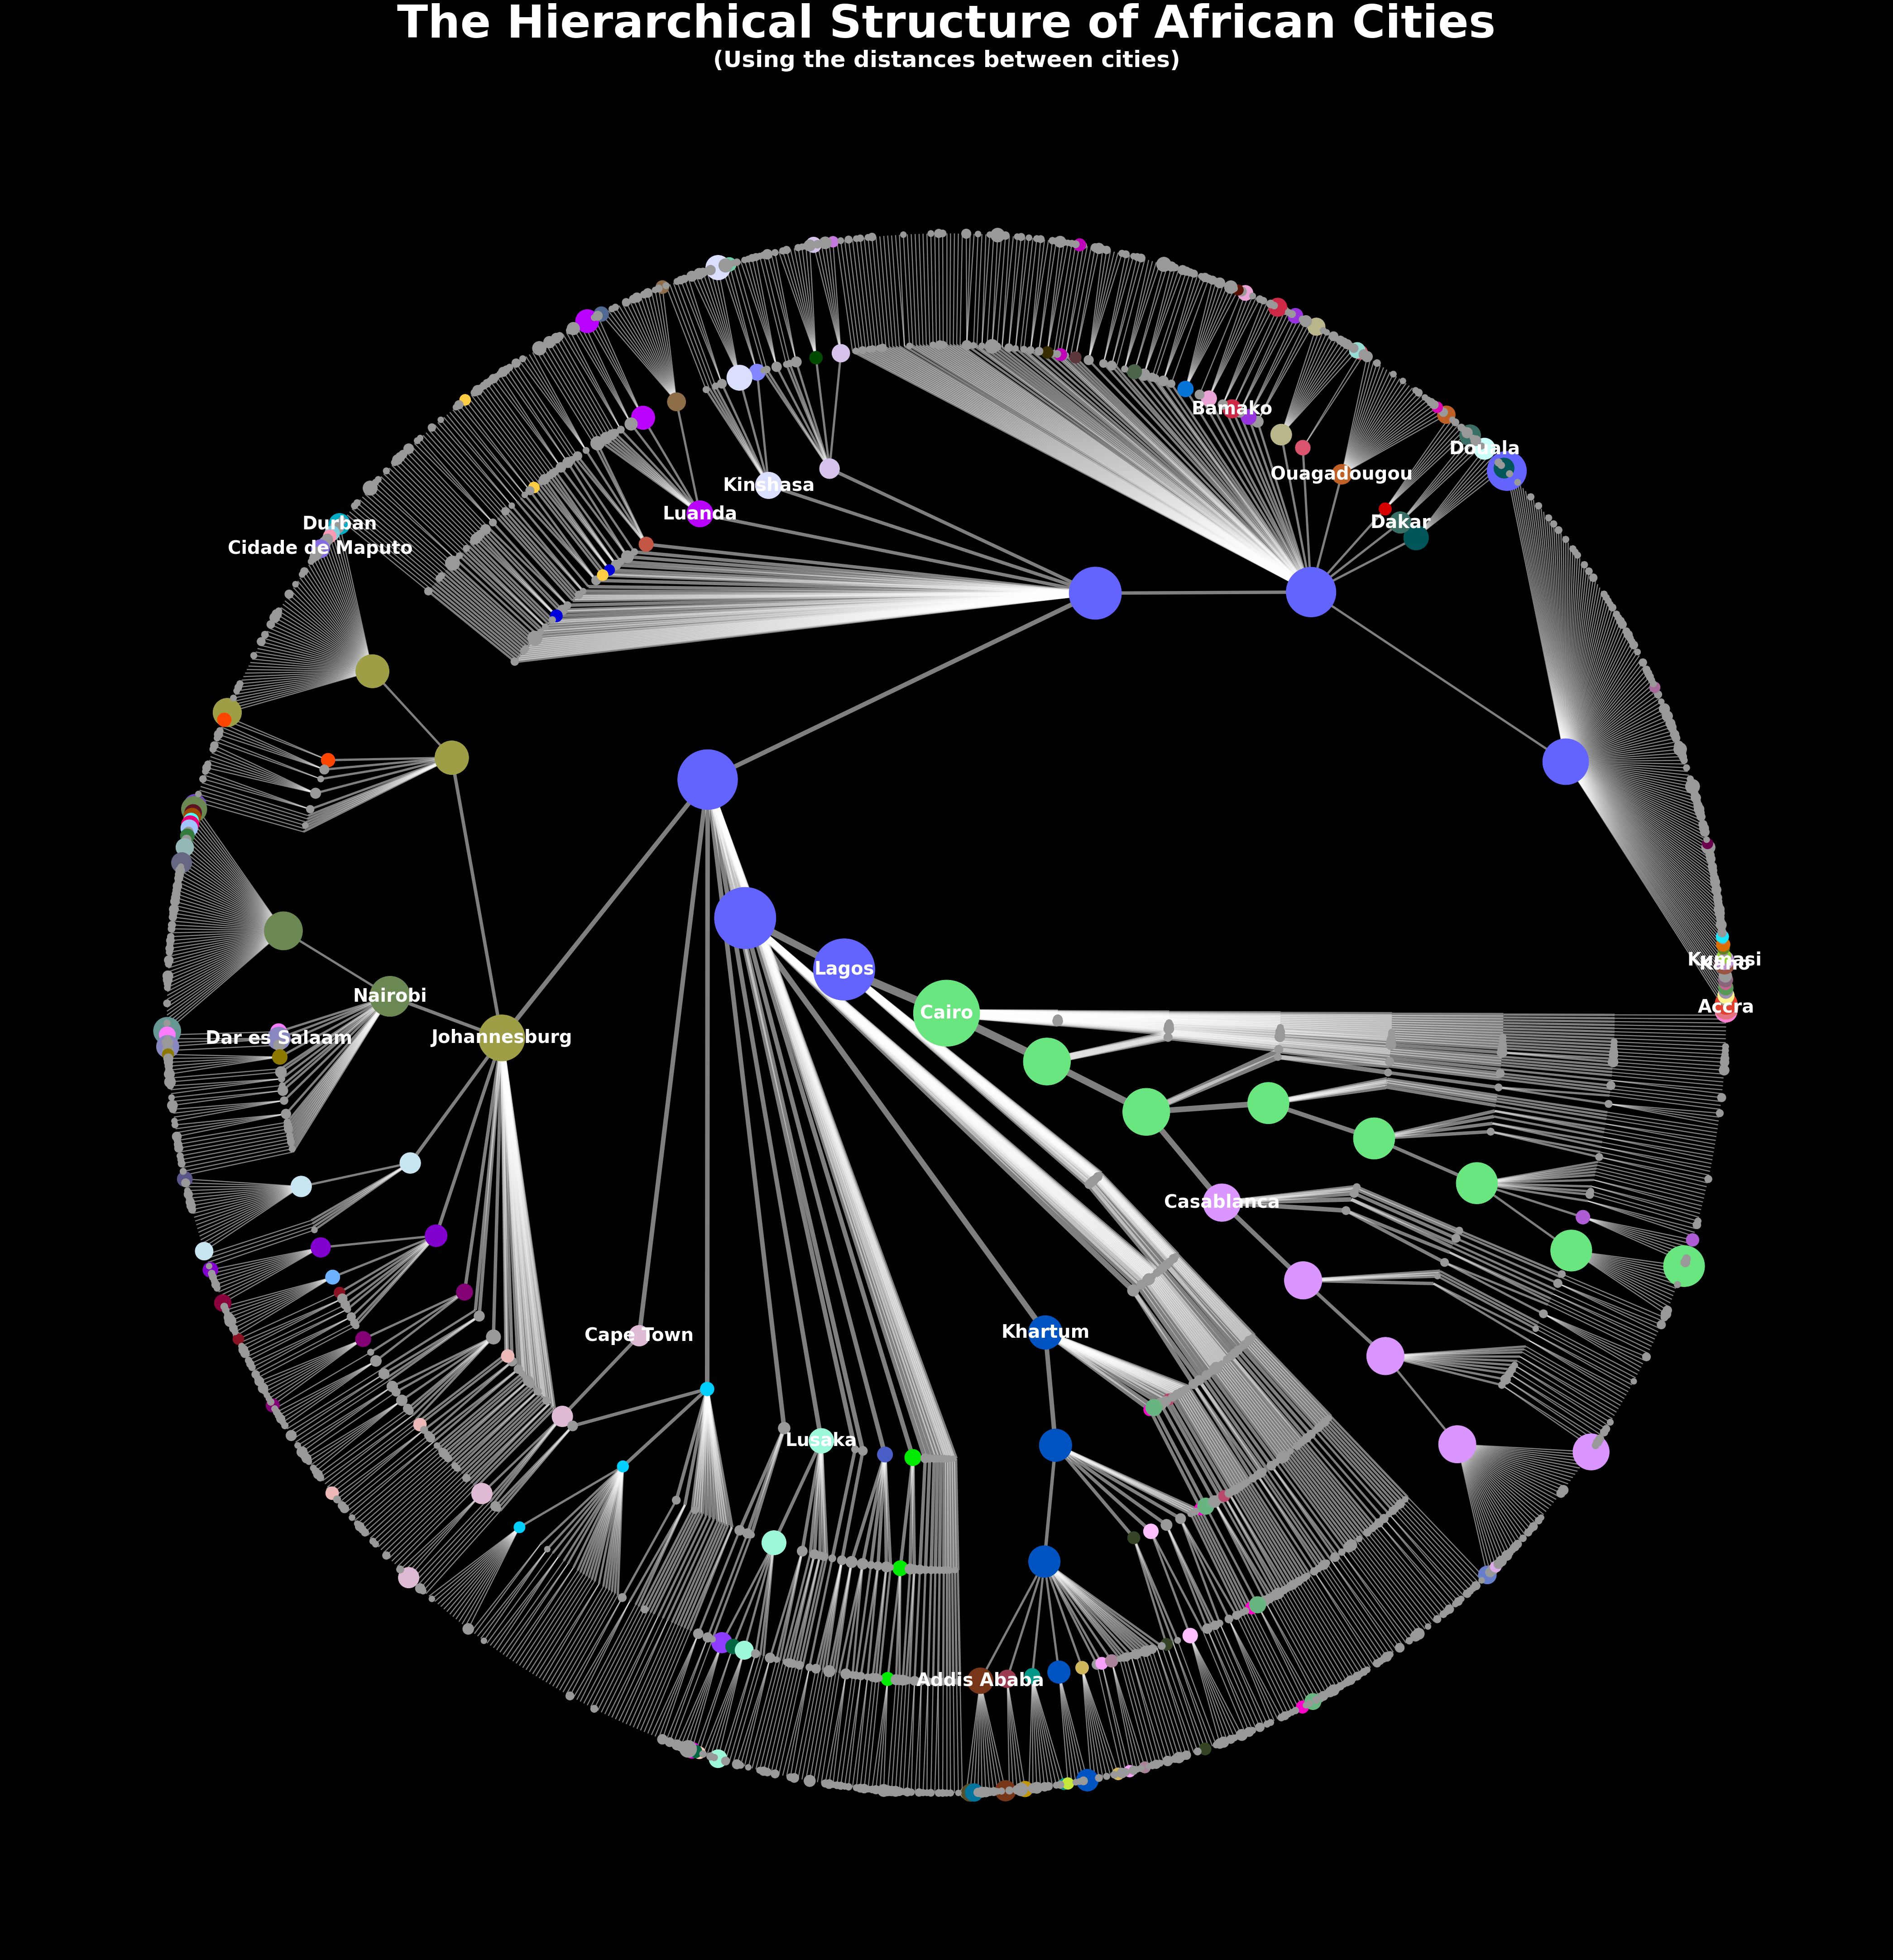

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(60, 60), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

pos = nx.nx_agraph.graphviz_layout(G_comp, prog="twopi", args="")

nx.draw_networkx_edges(G_comp, ax=ax, pos=pos, alpha=0.5, edge_color='w', width=[d['thrid'] / 20 for u, v, d in G_comp.edges(data=True)])
nx.draw_networkx_nodes(G_comp, ax=ax, pos=pos, alpha=1, node_color=[d['color'] for n, d in G_comp.nodes(data=True)], cmap=pal, node_size=[np.sqrt(d['pop_total']) for n, d in G_comp.nodes(data=True)])
nx.draw_networkx_labels(G_comp, ax=ax, pos=pos, labels=node_labels, font_color='w', font_size=40, font_weight='bold')
# easier way to get all nodes: {n: d['aggnm'] for n, d in G_comp.nodes(data=True)}

ax.set_facecolor('k')
ax.set_title('(Using the distances between cities)', color='w', size=50, weight='bold')

fig.suptitle('The Hierarchical Structure of African Cities', color='w', size=100, weight='bold')